In [2]:
import numpy as np
from sklearn.cluster import KMeans
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


In [3]:
path = os.path.join("open_bandit_dataset", "random", "men", "men.csv")
dataset = pd.read_csv(path,  index_col=0)

In [4]:
full_dataset = dataset.copy()

In [5]:
dataset.drop(columns=["timestamp", "user_feature_0", "user_feature_1", "user_feature_2", "user_feature_3"], inplace= True)

In [6]:
dataset.head()

,item_id,position,click,propensity_score,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,...,user-item_affinity_24,user-item_affinity_25,user-item_affinity_26,user-item_affinity_27,user-item_affinity_28,user-item_affinity_29,user-item_affinity_30,user-item_affinity_31,user-item_affinity_32,user-item_affinity_33
0,0,1,0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25,3,0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23,2,0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25,1,0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30,2,0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
kmeans = KMeans(init="k-means++", n_clusters=4, random_state=0)

In [8]:
clusters =kmeans.fit_transform(dataset)

In [9]:
predict = kmeans.fit_predict(dataset)

In [10]:
full_dataset['clusters'] = predict

In [11]:
full_dataset['clusters']

0         1
1         2
2         2
3         2
4         3
         ..
452944    1
452945    1
452946    2
452947    1
452948    0
Name: clusters, Length: 452949, dtype: int32

In [12]:
cluster_1 = full_dataset.loc[full_dataset['clusters'] == 1]
cluster_2 = full_dataset.loc[full_dataset['clusters'] == 2]
cluster_0 = full_dataset.loc[full_dataset['clusters'] == 0]


In [13]:
cluster_1.shape

(134156, 44)

In [14]:
cluster_2.shape

(106615, 44)

In [15]:
path = os.path.join("open_bandit_dataset", "random", "men", "cluster_0.csv")
cluster_0.to_csv(path, index=False)

In [16]:
path = os.path.join("open_bandit_dataset", "random", "men", "cluster_1.csv")
cluster_1.to_csv(path, index=False)

In [17]:
path = os.path.join("open_bandit_dataset", "random", "men", "cluster_2.csv")
cluster_2.to_csv(path, index=False)

In [18]:
path = os.path.join("open_bandit_dataset", "random", "men", "men.csv")
cluster_0.to_csv(path, index=False)

In [19]:
from obp.dataset import OpenBanditDataset
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW
from obp.policy import Random, EpsilonGreedy, BernoulliTS
from obp.dataset import OpenBanditDataset
from obp.simulator.simulator import BanditEnvironmentSimulator, BanditPolicySimulator
import numpy as np

from obp.policy import BaseContextFreePolicy
from dataclasses import dataclass

from obp.policy import EpsilonGreedy, LinTS, LinUCB
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust
)
from obp.simulator import (
    calc_ground_truth_policy_value,
)

from sklearn.linear_model import LogisticRegression

In [20]:
dataset_cluster_0 = OpenBanditDataset(behavior_policy="random", campaign="men", data_path="open_bandit_dataset", dataset_name="men.csv")
bandit_feedback = dataset_cluster_0.obtain_batch_bandit_feedback()

In [21]:
dataset_cluster_0.n_actions

20

In [23]:
# define BernoulliTS as an evaluation policy
evaluation_policy = BernoulliTS(
    n_actions=dataset_cluster_0.n_actions, 
    len_list=dataset_cluster_0.len_list, 
    campaign="men",
    random_state=12345,
    policy_name = "random"
)

# compute the action choice probabilities of the evaluation policy via Monte Carlo simulation
action_dist = evaluation_policy.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback["n_rounds"],
)

In [24]:
# `action_dist` is an array of shape (n_rounds, n_actions, len_list) 
# representing the distribution over actions by the evaluation policy
action_dist

array([[[0.05021, 0.05007, 0.04986],
        [0.04817, 0.04992, 0.05012],
        [0.04998, 0.05008, 0.051  ],
        ...,
        [0.05049, 0.04976, 0.05033],
        [0.0515 , 0.05027, 0.04983],
        [0.05004, 0.0504 , 0.05007]],

       [[0.05021, 0.05007, 0.04986],
        [0.04817, 0.04992, 0.05012],
        [0.04998, 0.05008, 0.051  ],
        ...,
        [0.05049, 0.04976, 0.05033],
        [0.0515 , 0.05027, 0.04983],
        [0.05004, 0.0504 , 0.05007]],

       [[0.05021, 0.05007, 0.04986],
        [0.04817, 0.04992, 0.05012],
        [0.04998, 0.05008, 0.051  ],
        ...,
        [0.05049, 0.04976, 0.05033],
        [0.0515 , 0.05027, 0.04983],
        [0.05004, 0.0504 , 0.05007]],

       ...,

       [[0.05021, 0.05007, 0.04986],
        [0.04817, 0.04992, 0.05012],
        [0.04998, 0.05008, 0.051  ],
        ...,
        [0.05049, 0.04976, 0.05033],
        [0.0515 , 0.05027, 0.04983],
        [0.05004, 0.0504 , 0.05007]],

       [[0.05021, 0.05007, 0.04986],
  

In [25]:
# estimate the expected rewards by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset_cluster_0.n_actions,
    len_list=dataset_cluster_0.len_list,
    action_context=dataset_cluster_0.action_context,
    base_model=LogisticRegression(max_iter=1000, random_state=12345),
)

In [26]:
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    position=bandit_feedback["position"],
    pscore=bandit_feedback["pscore"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

In [27]:
# estimate the policy value of BernoulliTS based on its action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist, 
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling.
    random_state=12345,
)

In [28]:
# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy 
# relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value

,estimated_policy_value,relative_estimated_policy_value
ipw,0.009076,1.704065
dm,0.005936,1.114626
dr,0.005864,1.101110


c:\Users\jlira\AppData\Local\Programs\Python\Python312\Lib\site-packages\obp-0.5.5-py3.12.egg\obp\ope\meta.py:640: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95.0)` for the same effect.

  sns.barplot(


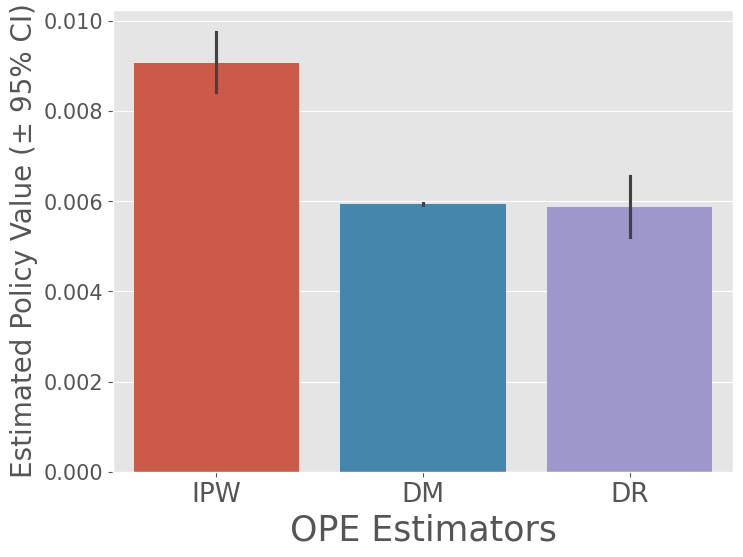

In [29]:
# visualize the estimated policy values of BernoulliTS and their 95% confidence intervals (estimated by bootstrap)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

c:\Users\jlira\AppData\Local\Programs\Python\Python312\Lib\site-packages\obp-0.5.5-py3.12.egg\obp\ope\meta.py:640: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95.0)` for the same effect.

  sns.barplot(


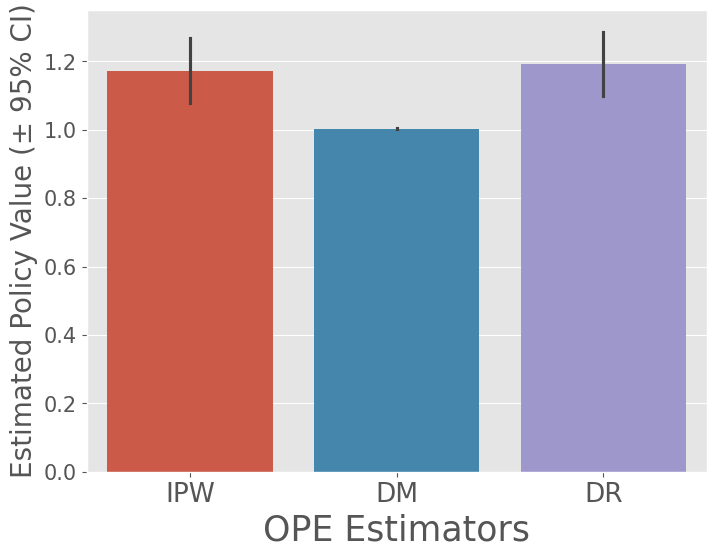

In [33]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    is_relative=True,
    random_state=12345,
)